### Environment Setup

In [1]:
import os
import wandb # для логирования
from PIL import Image
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as plt
import random
from tqdm import *

try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary
    
from torch.utils.data import TensorDataset, DataLoader,Dataset, random_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim # для оптимизаторов
import torchvision.transforms as transforms # для преобразований тензоров

import matplotlib.pyplot as plt

In [2]:
#!pip install -q torchinfo

In [3]:
def seed_everything(seed):
    random.seed(seed) # фиксируем генератор случайных чисел
    os.environ['PYTHONHASHSEED'] = str(seed) # фиксируем заполнения хешей
    np.random.seed(seed) # фиксируем генератор случайных чисел numpy
    torch.manual_seed(seed) # фиксируем генератор случайных чисел pytorch
    torch.cuda.manual_seed(seed) # фиксируем генератор случайных чисел для GPU
    torch.backends.cudnn.deterministic = True # выбираем только детерминированные алгоритмы (для сверток)
    torch.backends.cudnn.benchmark = False # фиксируем алгоритм вычисления сверток

In [4]:
class CFG:

# Задаем параметры нашего эксперимента


  num_epochs = 10 # количество эпох
  train_batch_size = 32 # размер батча обучающей выборки
  test_batch_size = 512 # размер батча тестовой выборки
  num_workers = 8 # количество активных процессов на загрузку данных
  lr = 0.001 # learning_rate
  seed = 2022 # для функции воспроизводимости
  #classes = # ВАШ КОД ЗДЕСЬ # классы датасета
  wandb = False # флаг использования Wandb

In [5]:
def class2dict(f):
  return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

In [6]:
class2dict(CFG)

{'lr': 0.001,
 'num_epochs': 10,
 'num_workers': 8,
 'seed': 2022,
 'test_batch_size': 512,
 'train_batch_size': 32,
 'wandb': False}

In [7]:
df = pd.read_csv(r"C:\Users\dm199\Downloads\histopathologic-cancer-detection\train_labels.csv")
df

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0
...,...,...
220020,53e9aa9d46e720bf3c6a7528d1fca3ba6e2e49f6,0
220021,d4b854fe38b07fe2831ad73892b3cec877689576,1
220022,3d046cead1a2a5cbe00b2b4847cfb7ba7cf5fe75,0
220023,f129691c13433f66e1e0671ff1fe80944816f5a2,0


### Basic EDA

In [8]:
df['label'].value_counts()

0    130908
1     89117
Name: label, dtype: int64

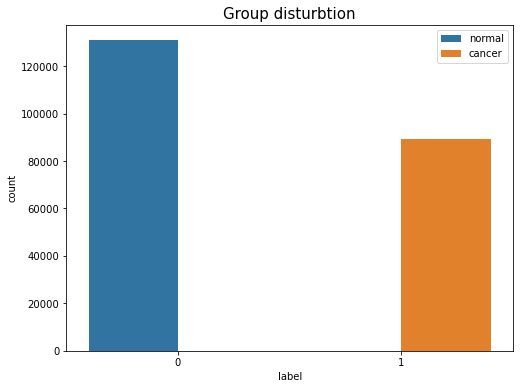

In [9]:
plt.figure(figsize = (8, 6), facecolor='white')
sns.countplot(data = df, x = df['label'], hue = 'label');
plt.title('Group disturbtion', fontsize=15)
plt.legend(labels = ['normal', 'cancer'])


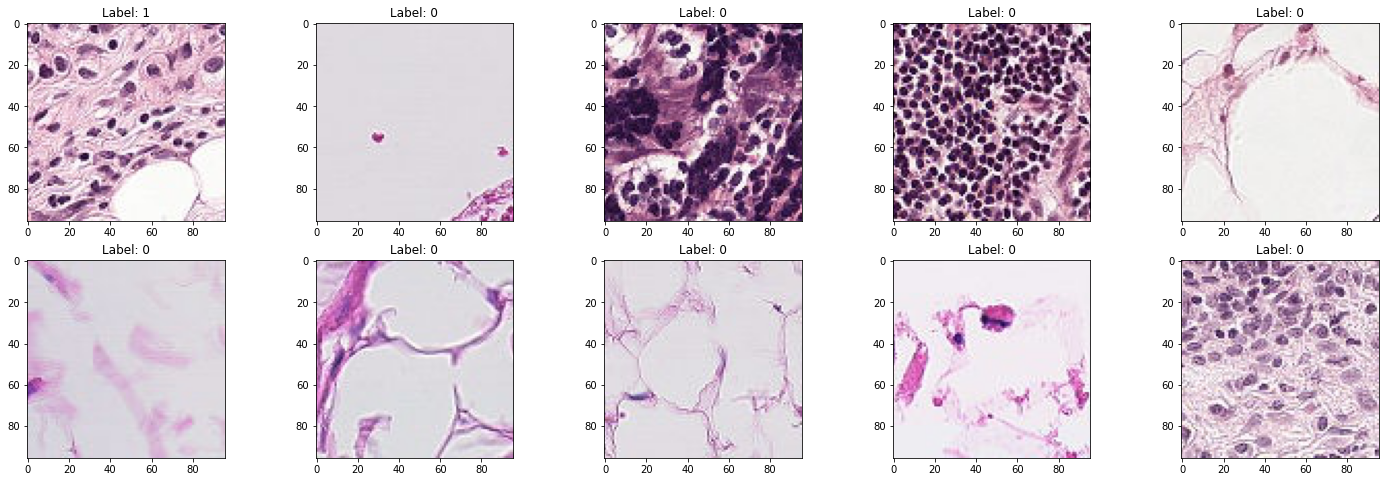

In [10]:
fig = plt.figure(figsize=(25, 8))
path2data = r'C:\Users\dm199\Downloads\histopathologic-cancer-detection\train'
train_imgs = os.listdir(path2data)
for idx, img in enumerate(np.random.choice(train_imgs, 10)):
    ax = fig.add_subplot(2, 5, idx+1)
    im = Image.open(path2data + "/" + img)
    plt.imshow(im)
    labels = df.loc[df["id"] == img.split('.')[0], 'label'].values[0]
    ax.set_title(f'Label: {labels}')

### Preparing the training & validation data

In [11]:
class cancer_dataset(Dataset):
    def __init__(self, data_dir, transform, data_type="train"):
        # path to images
        path2data = os.path.join(data_dir, data_type)
        
        # list of images in directory
        filenames = os.listdir(path2data)
        
        # get full path to images
        self.full_filenames = [os.path.join(path2data, f) for f in filenames]
        
        # get labels
        path2labels = os.path.join(data_dir, "train_labels.csv")
        labels_df = pd.read_csv(path2labels)
        
        # set dataframe index to id
        labels_df.set_index("id", inplace=True)
        
        # obtain labels from df
        self.labels = [labels_df.loc[filename[:-4]].values[0] for filename in filenames]
        
        self.transform = transform
        
        
    def __len__(self):
        # return size of dataset
        return len(self.full_filenames)
    
    def __getitem__(self, idx):
        # open image, apply transforms and return with label
        img = Image.open(self.full_filenames[idx]) # PIL image
        img = self.transform(img)
        return img, self.labels[idx]

In [12]:
data_transformer = transforms.Compose([transforms.CenterCrop(32),
                                       transforms.ToTensor()
                                       
                                       #transforms.Resize((48,48))
                                      ]) 

In [13]:
data_dir = r'C:\Users\dm199\Downloads\histopathologic-cancer-detection'
img_dataset = cancer_dataset(data_dir, data_transformer, "train")

In [14]:
img, label = img_dataset[19]
print(img.shape, torch.min(img), torch.max(img))

torch.Size([3, 32, 32]) tensor(0.) tensor(1.)


### Splitting the Dataset

In [15]:
len_dataset = len(img_dataset)
len_train = int(0.8 * len_dataset)
len_val = len_dataset - len_train

train_ds, val_ds = random_split(img_dataset, [len_train, len_val])

print(f'train dataset length: {len(train_ds)}')
print(f'test dataset length: {len(val_ds)}')

train dataset length: 176020
test dataset length: 44005


### Image Transformation

### Dataloaders

In [16]:
train_loader = DataLoader(train_ds, batch_size=CFG.train_batch_size, shuffle=True)
test_loader = DataLoader(val_ds, batch_size=CFG.test_batch_size, shuffle=False)


In [17]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples) # итерируемся по тестовым данным


In [18]:
example_data[0].shape

torch.Size([3, 32, 32])

### Base model

In [83]:
class My_Net(nn.Module): # наследуемся от класса nn.Module

    def __init__(self):
        super(My_Net,self).__init__()
        
        # количество нейронов в скрытых слоях (256, 128)
        self.hidden_1 = 256
        self.hidden_2 = 128
        # первый слой (784(=28*28) -> hidden_1)
        self.fc1 = nn.Linear(3*32*32, self.hidden_1) 
        # второй слой (hidden_1 -> hidden_2)
        self.fc2 = nn.Linear(self.hidden_1, self.hidden_2)
        # третий (выходной) слой (hidden_2 -> 10 (классов))
        self.fc3 = nn.Linear(self.hidden_2, 2)

        
    def forward(self, x):
        # преобразуем батч картинок из (N, 28, 28) в (N, 784)
        x = x.view(-1, 3*32*32)
        # добавляем первый скрытый слой с ReLU активацией
        x = F.relu(self.fc1(x))
        # добавляем второй скрытый слой с ReLU активацией
        x = F.relu(self.fc2(x))
        # добавляем третий (выходной) слой
        x = self.fc3(x)
        return x

In [84]:
model = My_Net()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device) # переводим модель на GPU
print(model) # посмотрим на нашу модель

My_Net(
  (fc1): Linear(in_features=3072, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=2, bias=True)
)


In [86]:
summary(model=My_Net(), 
        input_size=(32, 3, 32, 32), # входной батч
        col_names=["input_size", "output_size", "num_params", 'trainable'], # что хотим посмотреть
        col_width=20)

Layer (type:depth-idx)                   Input Shape          Output Shape         Param #              Trainable
My_Net                                   [32, 3, 32, 32]      [32, 2]              --                   True
├─Linear: 1-1                            [32, 3072]           [32, 256]            786,688              True
├─Linear: 1-2                            [32, 256]            [32, 128]            32,896               True
├─Linear: 1-3                            [32, 128]            [32, 2]              258                  True
Total params: 819,842
Trainable params: 819,842
Non-trainable params: 0
Total mult-adds (M): 26.23
Input size (MB): 0.39
Forward/backward pass size (MB): 0.10
Params size (MB): 3.28
Estimated Total Size (MB): 3.77

In [87]:
main(model)


Epoch: 1


100%|██████████| 5501/5501 [04:00<00:00, 22.85it/s]



Train set: Average loss: 0.6887, Accuracy: 58%
Test set: Average loss: 0.6896, Accuracy: 58%

Epoch: 2


100%|██████████| 5501/5501 [03:58<00:00, 23.08it/s]



Train set: Average loss: 0.6925, Accuracy: 58%
Test set: Average loss: 0.6896, Accuracy: 58%

Epoch: 3


100%|██████████| 5501/5501 [04:49<00:00, 19.02it/s]



Train set: Average loss: 0.6851, Accuracy: 58%
Test set: Average loss: 0.6896, Accuracy: 58%

Epoch: 4


100%|██████████| 5501/5501 [03:53<00:00, 23.52it/s]



Train set: Average loss: 0.6903, Accuracy: 58%
Test set: Average loss: 0.6896, Accuracy: 58%

Epoch: 5


100%|██████████| 5501/5501 [06:33<00:00, 13.99it/s]



Train set: Average loss: 0.6923, Accuracy: 58%
Test set: Average loss: 0.6896, Accuracy: 58%

Epoch: 6


100%|██████████| 5501/5501 [04:52<00:00, 18.80it/s]



Train set: Average loss: 0.6942, Accuracy: 58%
Test set: Average loss: 0.6896, Accuracy: 58%

Epoch: 7


100%|██████████| 5501/5501 [04:32<00:00, 20.21it/s]



Train set: Average loss: 0.6866, Accuracy: 58%
Test set: Average loss: 0.6896, Accuracy: 58%

Epoch: 8


100%|██████████| 5501/5501 [04:03<00:00, 22.59it/s]



Train set: Average loss: 0.6877, Accuracy: 58%
Test set: Average loss: 0.6896, Accuracy: 58%

Epoch: 9


100%|██████████| 5501/5501 [04:07<00:00, 22.24it/s]



Train set: Average loss: 0.6922, Accuracy: 58%
Test set: Average loss: 0.6896, Accuracy: 58%

Epoch: 10


100%|██████████| 5501/5501 [04:08<00:00, 22.18it/s]



Train set: Average loss: 0.6890, Accuracy: 58%
Test set: Average loss: 0.6896, Accuracy: 58%
Training is end!


In [78]:
# функция потерь (cross-entropy) для 10 классов
criterion = nn.CrossEntropyLoss()

# SGD (классический) со скоростью обучения (learning rate) = 0.01
optimizer = torch.optim.Adam(params=model.parameters(),
                           lr=0.001)

In [81]:
# функция обучения модели
def train(model, device, train_loader, optimizer, criterion, epoch, WANDB):
    model.train() # обязательно переводим в режим обучения
    test_loss = 0
    correct = 0
    
    n_ex = len(train_loader)
    
    for batch_idx, (data, target) in tqdm(enumerate(train_loader), total=n_ex):
        data, target = data.to(device), target.to(device) # переводим картинки и таргеты на GPU
        # обнуляем градиенты!
        optimizer.zero_grad()
        # прямой проход
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item() # определяем корректность предсказания
        train_loss = criterion(output, target) # считаем значение функции потерь
        # обратный проход
        train_loss.backward()
        # делаем градиентный шаг оптимизатором
        optimizer.step()
        # считаем метрики и лосс
    tqdm.write('\nTrain set: Average loss: {:.4f}, Accuracy: {:.0f}%'.format(
        train_loss, 100. * correct / len(train_loader.dataset)))
    
    if WANDB:
        wandb.log({'train_loss': train_loss,
                   'train_accuracy': correct / len(train_loader.dataset)})

In [68]:
# функция тестирования
def test(model, device, test_loader, criterion, WANDB):
    model.eval() # переводем модель в режим инференса
    test_loss = 0
    correct = 0
    # показываем, что обученич нет и градиенты не обновляются
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss = criterion(output, target) # считаем значение функции потерь
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            # считаем метрики
    tqdm.write('Test set: Average loss: {:.4f}, Accuracy: {:.0f}%'.format(
        test_loss, 100. * correct / len(test_loader.dataset)))
    
    if WANDB:
        wandb.log({'test_loss': test_loss,
                   'test_accuracy': correct / len(test_loader.dataset)})

In [82]:
# основная функция для экспериментов
def main(model):
    # настраиваем окружение для wandb
    if CFG.wandb:
        os.environ["WANDB_API_KEY"] = CFG.api
        wandb.init(project=CFG.project, entity=CFG.entity, reinit=True, config=class2dict(CFG))
  
    use_cuda =torch.cuda.is_available() # проверяем доступность GPU 

    seed_everything(CFG.seed) # фиксируем сиды

    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') # выделили устройство  
    
    if CFG.wandb:
        wandb.watch(model, log='all') # логируем все (метрики, лоссы, градиенты)

    for epoch in range(1, CFG.num_epochs + 1): # цикл на эпохи
        print('\nEpoch:', epoch)
        train(model, device, train_loader, optimizer, criterion, epoch, CFG.wandb)
        test(model, device, test_loader, criterion, CFG.wandb)
    print('Training is end!')

In [70]:
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.batch_norm0 = torch.nn.BatchNorm2d(3)


        self.conv1 = torch.nn.Conv2d(3, 16, 3, padding=1)
        self.act1  = torch.nn.ReLU()

       
        self.pool1 = torch.nn.MaxPool2d(2, 2)
        
        self.conv2 = torch.nn.Conv2d(16, 32, 3, padding=1)
        self.act2  = torch.nn.ReLU()

        
        self.pool2 = torch.nn.MaxPool2d(2, 2)
        
        self.conv3 = torch.nn.Conv2d(32, 64, 3, padding=1)
        self.act3  = torch.nn.ReLU()
        

        self.fc1   = torch.nn.Linear(8 * 8 * 64, 256)
        self.act4  = torch.nn.ReLU()
        self.batch_norm4 = torch.nn.BatchNorm1d(256)
        
        self.fc2   = torch.nn.Linear(256, 64)
        self.act5  = torch.nn.ReLU()
        
        
        self.fc3   = torch.nn.Linear(64, 2)
    
    def forward(self, x):
        
        x = self.batch_norm0(x)
        x = self.conv1(x)
        x = self.act1(x)
        
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.act2(x)
        
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.act3(x)
       

        x = x.view(-1, x.size(1) * x.size(2) * x.size(3))
        
        x = self.fc1(x)
        x = self.act4(x)
        x = self.batch_norm4(x)
        x = self.fc2(x)
        x = self.act5(x)
       
        x = self.fc3(x)
        
        return x

In [71]:
model = CNN()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device) # переводим модель на GPU
print(model) # посмотрим на нашу модель

CNN(
  (batch_norm0): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (fc1): Linear(in_features=4096, out_features=256, bias=True)
  (act4): ReLU()
  (batch_norm4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=256, out_features=64, bias=True)
  (act5): ReLU()
  (fc3): Linear(in_features=64, out_features=2, bias=True)
)


In [72]:
summary(model=CNN(), 
        input_size=(32, 3, 32, 32), # входной батч
        col_names=["input_size", "output_size", "num_params", 'trainable'], # что хотим посмотреть
        col_width=20)

Layer (type:depth-idx)                   Input Shape          Output Shape         Param #              Trainable
CNN                                      [32, 3, 32, 32]      [32, 2]              --                   True
├─BatchNorm2d: 1-1                       [32, 3, 32, 32]      [32, 3, 32, 32]      6                    True
├─Conv2d: 1-2                            [32, 3, 32, 32]      [32, 16, 32, 32]     448                  True
├─ReLU: 1-3                              [32, 16, 32, 32]     [32, 16, 32, 32]     --                   --
├─MaxPool2d: 1-4                         [32, 16, 32, 32]     [32, 16, 16, 16]     --                   --
├─Conv2d: 1-5                            [32, 16, 16, 16]     [32, 32, 16, 16]     4,640                True
├─ReLU: 1-6                              [32, 32, 16, 16]     [32, 32, 16, 16]     --                   --
├─MaxPool2d: 1-7                         [32, 32, 16, 16]     [32, 32, 8, 8]       --                   --
├─Conv2d: 1-8         

In [73]:
main(model)


Epoch: 1


100%|██████████| 5501/5501 [03:57<00:00, 23.12it/s]



Train set: Average loss: 0.7516, Accuracy: 45%
Test set: Average loss: 0.7393, Accuracy: 46%

Epoch: 2


100%|██████████| 5501/5501 [04:06<00:00, 22.30it/s]



Train set: Average loss: 0.7099, Accuracy: 45%
Test set: Average loss: 0.7390, Accuracy: 46%

Epoch: 3


 48%|████▊     | 2654/5501 [01:51<01:59, 23.79it/s]


KeyboardInterrupt: 

In [53]:
class CNN_v2(torch.nn.Module):
    def __init__(self):
        super(CNN_v2, self).__init__()
       


        self.conv1 = torch.nn.Conv2d(3, 16, 3, padding=1)
        self.act1  = torch.nn.ReLU()

        self.conv2 = torch.nn.Conv2d(16, 32, 3, padding=1)
        self.act2  = torch.nn.ReLU()


        self.conv3 = torch.nn.Conv2d(32, 64, 3, padding=1)
        self.act3  = torch.nn.ReLU()
        self.pool3 = torch.nn.MaxPool2d(2, 2)

        self.fc1   = torch.nn.Linear(16 * 16 * 64, 256)
        self.act4  = torch.nn.ReLU()
        self.batch_norm4 = torch.nn.BatchNorm1d(256)
        
        self.fc2   = torch.nn.Linear(256, 64)
        self.act5  = torch.nn.ReLU()
        
        
        self.fc3   = torch.nn.Linear(64, 2)
    
    def forward(self, x):
        
    
        x = self.conv1(x)
        x = self.act1(x)
        

        x = self.conv2(x)
        x = self.act2(x)
        
        x = self.conv3(x)
        x = self.act3(x)
        x = self.pool3(x)

        x = x.view(-1, x.size(1) * x.size(2) * x.size(3))
        
        x = self.fc1(x)
        x = self.act4(x)
        x = self.batch_norm4(x)
        x = self.fc2(x)
        x = self.act5(x)
       
        x = self.fc3(x)
        
        return x

In [54]:
model = CNN_v2()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device) # переводим модель на GPU
print(model) # посмотрим на нашу модель

CNN_v2(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=16384, out_features=256, bias=True)
  (act4): ReLU()
  (batch_norm4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=256, out_features=64, bias=True)
  (act5): ReLU()
  (fc3): Linear(in_features=64, out_features=2, bias=True)
)


In [55]:
summary(model=CNN_v2(), 
        input_size=(32, 3, 32, 32), # входной батч
        col_names=["input_size", "output_size", "num_params", 'trainable'], # что хотим посмотреть
        col_width=20)

Layer (type:depth-idx)                   Input Shape          Output Shape         Param #              Trainable
CNN_v2                                   [32, 3, 32, 32]      [32, 2]              --                   True
├─Conv2d: 1-1                            [32, 3, 32, 32]      [32, 16, 32, 32]     448                  True
├─ReLU: 1-2                              [32, 16, 32, 32]     [32, 16, 32, 32]     --                   --
├─Conv2d: 1-3                            [32, 16, 32, 32]     [32, 32, 32, 32]     4,640                True
├─ReLU: 1-4                              [32, 32, 32, 32]     [32, 32, 32, 32]     --                   --
├─Conv2d: 1-5                            [32, 32, 32, 32]     [32, 64, 32, 32]     18,496               True
├─ReLU: 1-6                              [32, 64, 32, 32]     [32, 64, 32, 32]     --                   --
├─MaxPool2d: 1-7                         [32, 64, 32, 32]     [32, 64, 16, 16]     --                   --
├─Linear: 1-8         

In [58]:
main(model)


Epoch: 1


100%|██████████| 5501/5501 [04:55<00:00, 18.60it/s]



Train set: Average loss: 0.4224, Accuracy: 80%
Test set: Average loss: 0.4902, Accuracy: 79%

Epoch: 2


100%|██████████| 5501/5501 [04:50<00:00, 18.95it/s]



Train set: Average loss: 0.2114, Accuracy: 81%
Test set: Average loss: 0.4982, Accuracy: 81%

Epoch: 3


100%|██████████| 5501/5501 [05:31<00:00, 16.57it/s]



Train set: Average loss: 0.4315, Accuracy: 83%
Test set: Average loss: 0.4574, Accuracy: 82%

Epoch: 4


100%|██████████| 5501/5501 [05:26<00:00, 16.86it/s]



Train set: Average loss: 0.1389, Accuracy: 84%
Test set: Average loss: 0.4815, Accuracy: 83%

Epoch: 5


100%|██████████| 5501/5501 [05:19<00:00, 17.23it/s]



Train set: Average loss: 0.6890, Accuracy: 86%
Test set: Average loss: 0.6724, Accuracy: 78%

Epoch: 6


100%|██████████| 5501/5501 [05:15<00:00, 17.43it/s]



Train set: Average loss: 0.4199, Accuracy: 87%
Test set: Average loss: 0.5292, Accuracy: 81%

Epoch: 7


100%|██████████| 5501/5501 [05:15<00:00, 17.45it/s]



Train set: Average loss: 0.4140, Accuracy: 89%
Test set: Average loss: 0.5601, Accuracy: 81%

Epoch: 8


100%|██████████| 5501/5501 [04:54<00:00, 18.70it/s]



Train set: Average loss: 0.6157, Accuracy: 91%
Test set: Average loss: 0.6572, Accuracy: 80%

Epoch: 9


100%|██████████| 5501/5501 [05:22<00:00, 17.05it/s]



Train set: Average loss: 0.0924, Accuracy: 92%
Test set: Average loss: 0.7393, Accuracy: 80%

Epoch: 10


100%|██████████| 5501/5501 [05:33<00:00, 16.51it/s]



Train set: Average loss: 0.1041, Accuracy: 93%
Test set: Average loss: 0.7309, Accuracy: 80%
Training is end!


Text(0.5, 1.0, 'Accuracy')

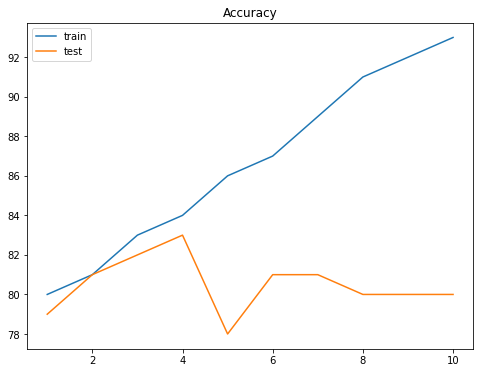

In [32]:
plt.figure(figsize = (8,6), facecolor='white')
sns.lineplot(x=[*range(1,11)],y=[ 80,81, 83, 84, 86, 87, 89, 91, 92, 93],label='train')
sns.lineplot(x=[*range(1,11)],y=[ 79, 81, 82, 83, 78, 81, 81, 80, 80, 80 ], label='test')
plt.title('Accuracy')

Text(0.5, 1.0, 'Loss')

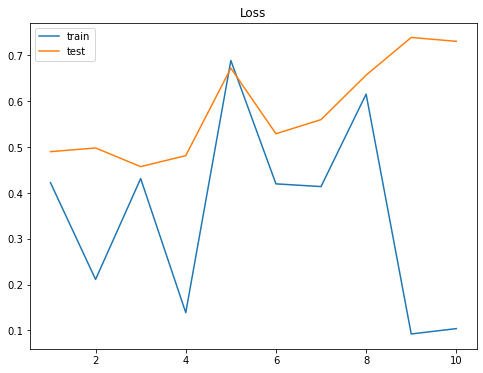

In [34]:
plt.figure(figsize = (8,6), facecolor='white')
sns.lineplot(x=[*range(1,11)],y=[ 0.4224, 0.2114, 0.4315, 0.1389, 0.6890, 0.4199, 0.4140, 0.6157, 0.0924, 0.1041],label='train')
sns.lineplot(x=[*range(1,11)],y=[ 0.4902, 0.4982, 0.4575, 0.4815, 0.6724, 0.5292, 0.5601, 0.6572, 0.7393, 0.7309], label='test')
plt.title('Loss')